In [8]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
from os.path import expanduser
import pickle
import random
import time
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [28]:
from sklearn.utils import shuffle

In [11]:
IDENTS_DF = '/media/big-ssd/experiments/P3856/identifications-pasef/exp-P3856-identifications-pasef.feather'
MAXIMUM_Q_VALUE_FOR_RECAL_TRAINING_SET = 0.005

In [12]:
idents_df = pd.read_feather(IDENTS_DF)
idents_df = idents_df[(idents_df['percolator q-value'] <= MAXIMUM_Q_VALUE_FOR_RECAL_TRAINING_SET)]
idents_df = idents_df[['run_name','monoisotopic_mz','scan_apex','rt_apex','feature_intensity','mass_error']]

In [13]:
X = idents_df[['monoisotopic_mz','scan_apex','rt_apex','feature_intensity']].to_numpy()
y = idents_df[['mass_error']].to_numpy()[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

#### build the training set

In [25]:
train_proportion = 0.8
test_proportion = 0.1
val_proportion = 0.1

In [26]:
len(idents_df)

8580

In [27]:
train_n = int(train_proportion * len(idents_df))
valid_n = int(val_proportion * len(idents_df))
test_n = len(idents_df) - train_n - valid_n

In [29]:
idents_df = shuffle(idents_df)
train_df = idents_df[0:train_n]
valid_df = idents_df[train_n+1:train_n+valid_n]
test_df = idents_df[train_n+valid_n+1:]

In [30]:
train_df.to_pickle('{}/train_df.pkl'.format(expanduser('~')))
valid_df.to_pickle('{}/valid_df.pkl'.format(expanduser('~')))
test_df.to_pickle('{}/test_df.pkl'.format(expanduser('~')))

In [32]:
print('train: {} ({}%), validation: {} ({}%), test: {} ({}%)'.format(len(train_df), round(len(train_df)/len(idents_df)*100), len(test_df), round(len(test_df)/len(idents_df)*100), len(valid_df), round(len(valid_df)/len(idents_df)*100)))


train: 6864 (80%), validation: 857 (10%), test: 857 (10%)


In [34]:
input_names = ['monoisotopic_mz','scan_apex','rt_apex','feature_intensity']

In [35]:
X_train = train_df[input_names].to_numpy()
y_train = train_df[['mass_error']].to_numpy()[:,0]

In [36]:
X_valid = valid_df[input_names].to_numpy()
y_valid = valid_df[['mass_error']].to_numpy()[:,0]

In [37]:
X_test = test_df[input_names].to_numpy()
y_test = test_df[['mass_error']].to_numpy()[:,0]

In [128]:
# define the keras model
model = Sequential()

model.add(BatchNormalization(input_shape=(4,)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))

model.add(BatchNormalization())
model.add(Dense(1))

In [129]:
# compile the keras model
model.compile(loss='mean_absolute_error', optimizer='adam')

In [130]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_26 (Batc (None, 4)                 16        
_________________________________________________________________
dense_26 (Dense)             (None, 128)               640       
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 128)               512       
_________________________________________________________________
dense_27 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 128)              

In [131]:
# for visualisation
tf.keras.models.save_model(model, "{}/model.h5".format(expanduser('~')))

In [132]:
# fit the keras model on the dataset
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_valid, y_valid),
                    epochs=200, 
                    batch_size=512,
                    verbose=0)

In [133]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

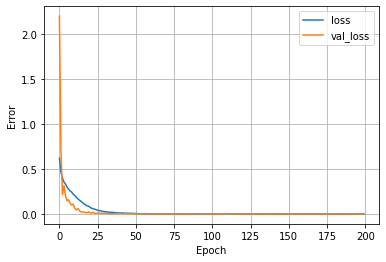

In [134]:
plot_loss(history)

#### evaluate the model on the test data

In [137]:
results = model.evaluate(X_test, y_test, batch_size=128)
print("test mean_absolute_error:", results)

7/7 [==============================] - 0s 2ms/step - loss: 0.0033
test mean_absolute_error: 0.0032500987872481346
